# Cubed sphere grid explanation with Weimer potential

Create a figure explaining the cubed sphere grid. Using the Weimer () potential.

The cubed sphere grid objects have differentiation matrices $\mathbb D_e$, $\mathbb D_n$, as well as a matrix $\mathbb D_{\nabla\cdot}$ which, when applied to a vector field $V$ produces the divergence of $V$. 


Below we:
 1. Set up the cubed sphere grid
 2. Read a Weimer model output file
 3. Get east, north electric fields
 4. Get divergence of electric field - multiply by $\epsilon_0$ to get charge density
 5. Plot
 
Import relevant modules:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import lompe

# TODO: are we placing grid on earth or in ionosphere?
R = 6371.2e3 # Earth radius
B0 = 3.12e-5 # Mean magnetic field
eps = 8.854e-12 # vacuum permittivity
stencil_size = 3 # size of the stencil used for numerical differentiation

Set up cubed sphere grid:

In [2]:
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0) # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, 20000e3, 20000e3, 50e3, 50e3, R = R)
SKIP = 10 # how many grid points to skip when plotting vector fields

Next, read Weimer module output file, interpolate potential (scalar field, $\Phi$) on the grid, assuming a dipole magnetic field:

In [3]:
# read potential file:
weimer = pd.read_table('./weimer.txt', sep = ' ', skipinitialspace = True, comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# get lat, lon coordinates, convert to SI-units
latxx = weimer.mlat.values.reshape((181, 61))
lonxx = weimer.mlt .values.reshape((181, 61)) * 15 # mlt to lon
V     = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

# interpolate potential to cubedsphere grid:
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), fill_value = 0, method = 'linear', rescale = True).reshape(grid.shape)

When ignoring inductive effects the electric field can be related to the electrostatic potential though $\mathbf{E} = -\nabla\Phi$. We can thus differentiate $\Phi$ to get electric field components:
\begin{equation*}
    \mathbf{E}_e = -\mathbb D_e\cdot\Phi
\end{equation*}
\begin{equation*}
    \mathbf{E}_n = -\mathbb D_n\cdot\Phi
\end{equation*}

The grid object contains the matrices that produces derivative in eastward and northward direction of a scalar field (here: $\Phi$) on the grid: $\mathbb D_e$, $\mathbb D_n$.

    WHY RETURN SPARSE? STENCIL SIZE?

In [4]:
# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_e = -De.dot(V.flatten()).reshape(grid.shape)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)

$\mathbf{E}$ is a $2N$ element column vector $\mathbf{E}=\begin{pmatrix}\mathbf{E}_e\\\mathbf{E}_n\end{pmatrix}$, where $N$ is the number of grid cells.

We can also calculate the divergence of the electric field:
\begin{equation*}
    \nabla\cdot\mathbf{E} = \mathbb D_{\nabla\cdot}\begin{pmatrix}\mathbf{E}_e\\\mathbf{E}_n\end{pmatrix}
\end{equation*}

The grid object contains the matrix that produces the divergence of a vector field (here: $\mathbf{E}$) on the grid: $\mathbb D_{\nabla\cdot}$. $\mathbb D_{\nabla\cdot}$ is a $2N\times N$ matrix that operates on $\mathbf{E}$ that has length $2N$.

The divergence of the electric field is related to the charge density, $\rho_c$, through Gauss' law:
\begin{equation*}
    \rho_c = \epsilon_0\nabla\cdot\mathbf{E}
\end{equation*}
where $\epsilon_0$ is the permittivity of free space (constant).

    TODO: Check if dimensions are correct here

In [5]:
E_mat = np.concatenate((E_e.flatten(), E_n.flatten()))
# use cubedsphere divergence matrix to get div(E):
Ddiv = grid.divergence(S = stencil_size, return_sparse = True)
divE = Ddiv.dot(E_mat).reshape(grid.shape)

Smooth electric field and div(E) for plotting:

In [6]:
E_e = median_filter(E_e, size = 3*SKIP, mode = 'constant', cval = 0)
E_n = median_filter(E_n, size = 3*SKIP, mode = 'constant', cval = 0)
divE = median_filter(divE, size = 3*SKIP, mode = 'constant', cval = 0)
epsdivE = divE * eps # Faradays law

E_n[grid.lat < 60] = 0

    TODO: check that scales for E-field and epsdivE are correct

In [8]:
print(epsdivE.min())
print(epsdivE.max())

-5.167224680898275e-19
4.940979693030502e-19


Set up figure and plot:

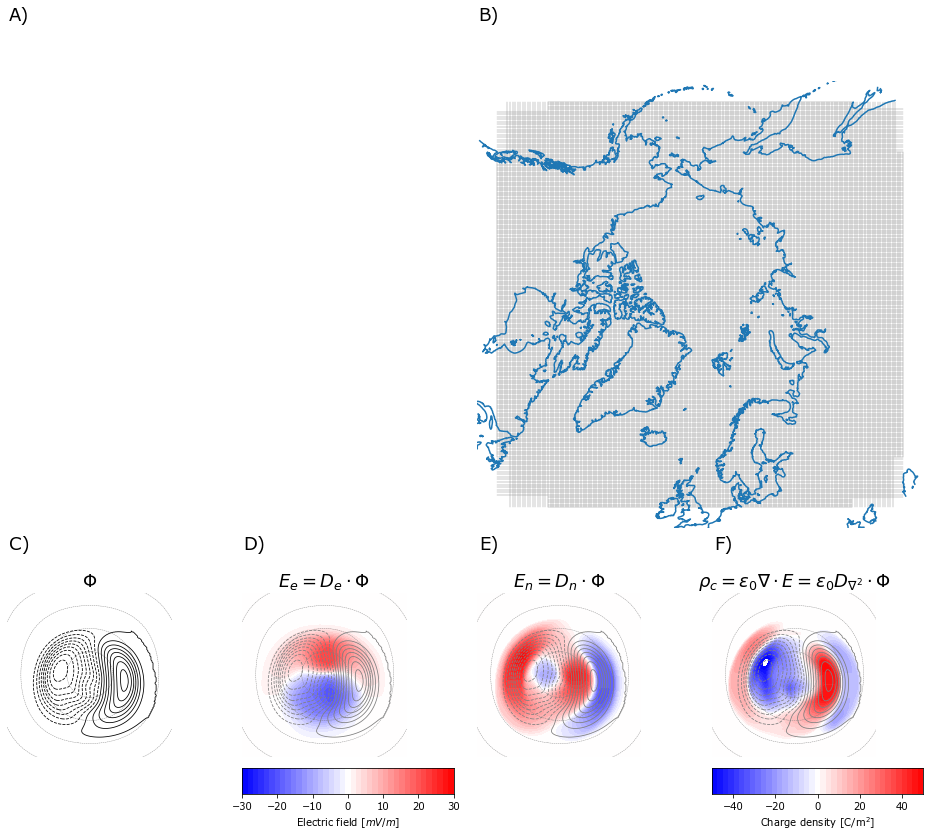

In [9]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (12*1.25, 9*1.25))

axs1, axs2 = {}, {} # initialize dictionaries for axes

# upper row
axs1['onsphere' ] = plt.subplot2grid((30, 40), (2,  0), rowspan = 19, colspan = 19)
axs1['grid'     ] = plt.subplot2grid((30, 40), (2, 20), rowspan = 19, colspan = 19)
axs1['label'    ] = plt.subplot2grid((30, 40), (1,  0))
axs1['label2'   ] = plt.subplot2grid((30, 40), (1, 20))

# lower row
axs2['potential'] = plt.subplot2grid((30, 40), (22,  0), rowspan = 7, colspan = 7)
axs2['E_e'      ] = plt.subplot2grid((30, 40), (22, 10), rowspan = 7, colspan = 7)
axs2['E_n'      ] = plt.subplot2grid((30, 40), (22, 20), rowspan = 7, colspan = 7)
axs2['Ediv'     ] = plt.subplot2grid((30, 40), (22, 30), rowspan = 7, colspan = 7)

axs2['label'    ] = plt.subplot2grid((30, 40), (21, 0))
axs2['label2'   ] = plt.subplot2grid((30, 40), (21, 10))
axs2['label3'   ] = plt.subplot2grid((30, 40), (21, 20))
axs2['label4'   ] = plt.subplot2grid((30, 40), (21, 30))

axs2['cbar'     ] = plt.subplot2grid((30, 40), (29, 10), colspan = 9) # for electric fields
axs2['cbar2'    ] = plt.subplot2grid((30, 40), (29, 30), colspan = 9) # for div(E)

plt.subplots_adjust(hspace = 0, wspace = 0, left = 0.05, right = .92, bottom = 0.01 ,top = .99)

# labels
axs1['label' ].set_title('A)', fontsize = 18)
axs1['label2'].set_title('B)', fontsize = 18)
axs2['label' ].set_title('C)', fontsize = 18)
axs2['label2'].set_title('D)', fontsize = 18)
axs2['label3'].set_title('E)', fontsize = 18)
axs2['label4'].set_title('F)', fontsize = 18)

###################### upper row of plots #########################

# set up axes for grid visualization
for key in axs1.keys():
    axs1[key].set_axis_off()
    if 'label' in key:
        continue
    axs1[key].set_aspect('equal')

# A) example of cube face intersecting sphere 
    
# B) cubed sphere grid with coastlines
# TODO: plot grid in a better way?
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    axs1['grid'].plot(xi[::20], eta[::20], color = 'grey', linewidth = .4) 

# add coastlines
xlim, ylim = axs1['grid'].get_xlim(), axs1['grid'].get_ylim()
for cl in grid.projection.get_projected_coastlines():
    axs1['grid'].plot(cl[0], cl[1], color = 'C0')

axs1['grid'].set_xlim(xlim)
axs1['grid'].set_ylim(ylim)

###################### lower row of plots #########################

# Set up axis for phi, Ee, En, divE
for key in axs2.keys():
    if 'cbar' in key: 
        continue
    axs2[key].set_axis_off()
    if 'label' in key:
        continue
    axs2[key].set_aspect('equal')
    axs2[key].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
    
# C) Potential
# f = Phi
axs2['potential'].set_title(r'$\Phi$', fontsize = 18)
axs2['potential'].contour(grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)

# color scale for east, north E-field
Elevels = np.linspace(-30, 30, 40) * 1e-3

# D) eastward electric field
# E_e = D_e * Phi
axs2['E_e'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['E_e'].contourf(grid.xi, grid.eta, E_e, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_e'].set_title(r'$E_e = D_e \cdot \Phi$', fontsize = 18)

# E) northward electric field
# E_n = D_n * Phi
axs2['E_n'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['E_n'].contourf(grid.xi, grid.eta, E_n, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_n'].set_title(r'$E_n = D_n \cdot \Phi$', fontsize = 18)

# color bar for east, north electric fields
x = np.vstack((Elevels, Elevels)).T
y = np.vstack((np.zeros(Elevels.size), np.ones(Elevels.size))).T
axs2['cbar'].contourf(x*1e3, y, x*1e3, levels = Elevels*1e3, cmap = plt.cm.bwr)
axs2['cbar'].set_yticks([])
axs2['cbar'].xaxis.set_label_position("bottom")
axs2['cbar'].xaxis.tick_bottom()
axs2['cbar'].set_xlabel('Electric field [$mV/m$]')


# F) charge density

# color scale for charge density (eps*divE)
divElevels = np.linspace(-50, 50, 40) * 1e-20

# divE = D_div * E
# epsdivE = eps*divE
axs2['Ediv'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['Ediv'].contourf(grid.xi, grid.eta, epsdivE, cmap = plt.cm.bwr, levels = divElevels)
axs2['Ediv'].set_title(r'$\rho_c=\epsilon_0 \nabla \cdot E = \epsilon_0 D_{\nabla^2} \cdot \Phi$', fontsize = 18);

# color bar for div(E)
x = np.vstack((divElevels, divElevels)).T
y = np.vstack((np.zeros(divElevels.size), np.ones(divElevels.size))).T
axs2['cbar2'].contourf(x*1e20, y, x*1e20, levels = divElevels*1e20, cmap = plt.cm.bwr)
axs2['cbar2'].set_yticks([])
axs2['cbar2'].xaxis.set_label_position("bottom")
axs2['cbar2'].xaxis.tick_bottom()
axs2['cbar2'].set_xlabel(r'Charge density [C/m$^2$]'); # really C/m^3
